In [60]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_manager.fontManager.addfont("./data/arial/ARIAL.TTF")
font_manager.fontManager.addfont("./data/arial/ARIALBD.TTF")

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'Arial',          # or 'sans-serif' if required by the journal
    'font.size': 12,                 # main font size
    'axes.labelsize': 13,            # axis labels
    'axes.titlesize': 13,            # title
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

INPUT_CSV = Path('./data/prepared_training_dataset.csv')

# Logistic Regression Greedy Feature Selection analysis

## Median AP across Targets

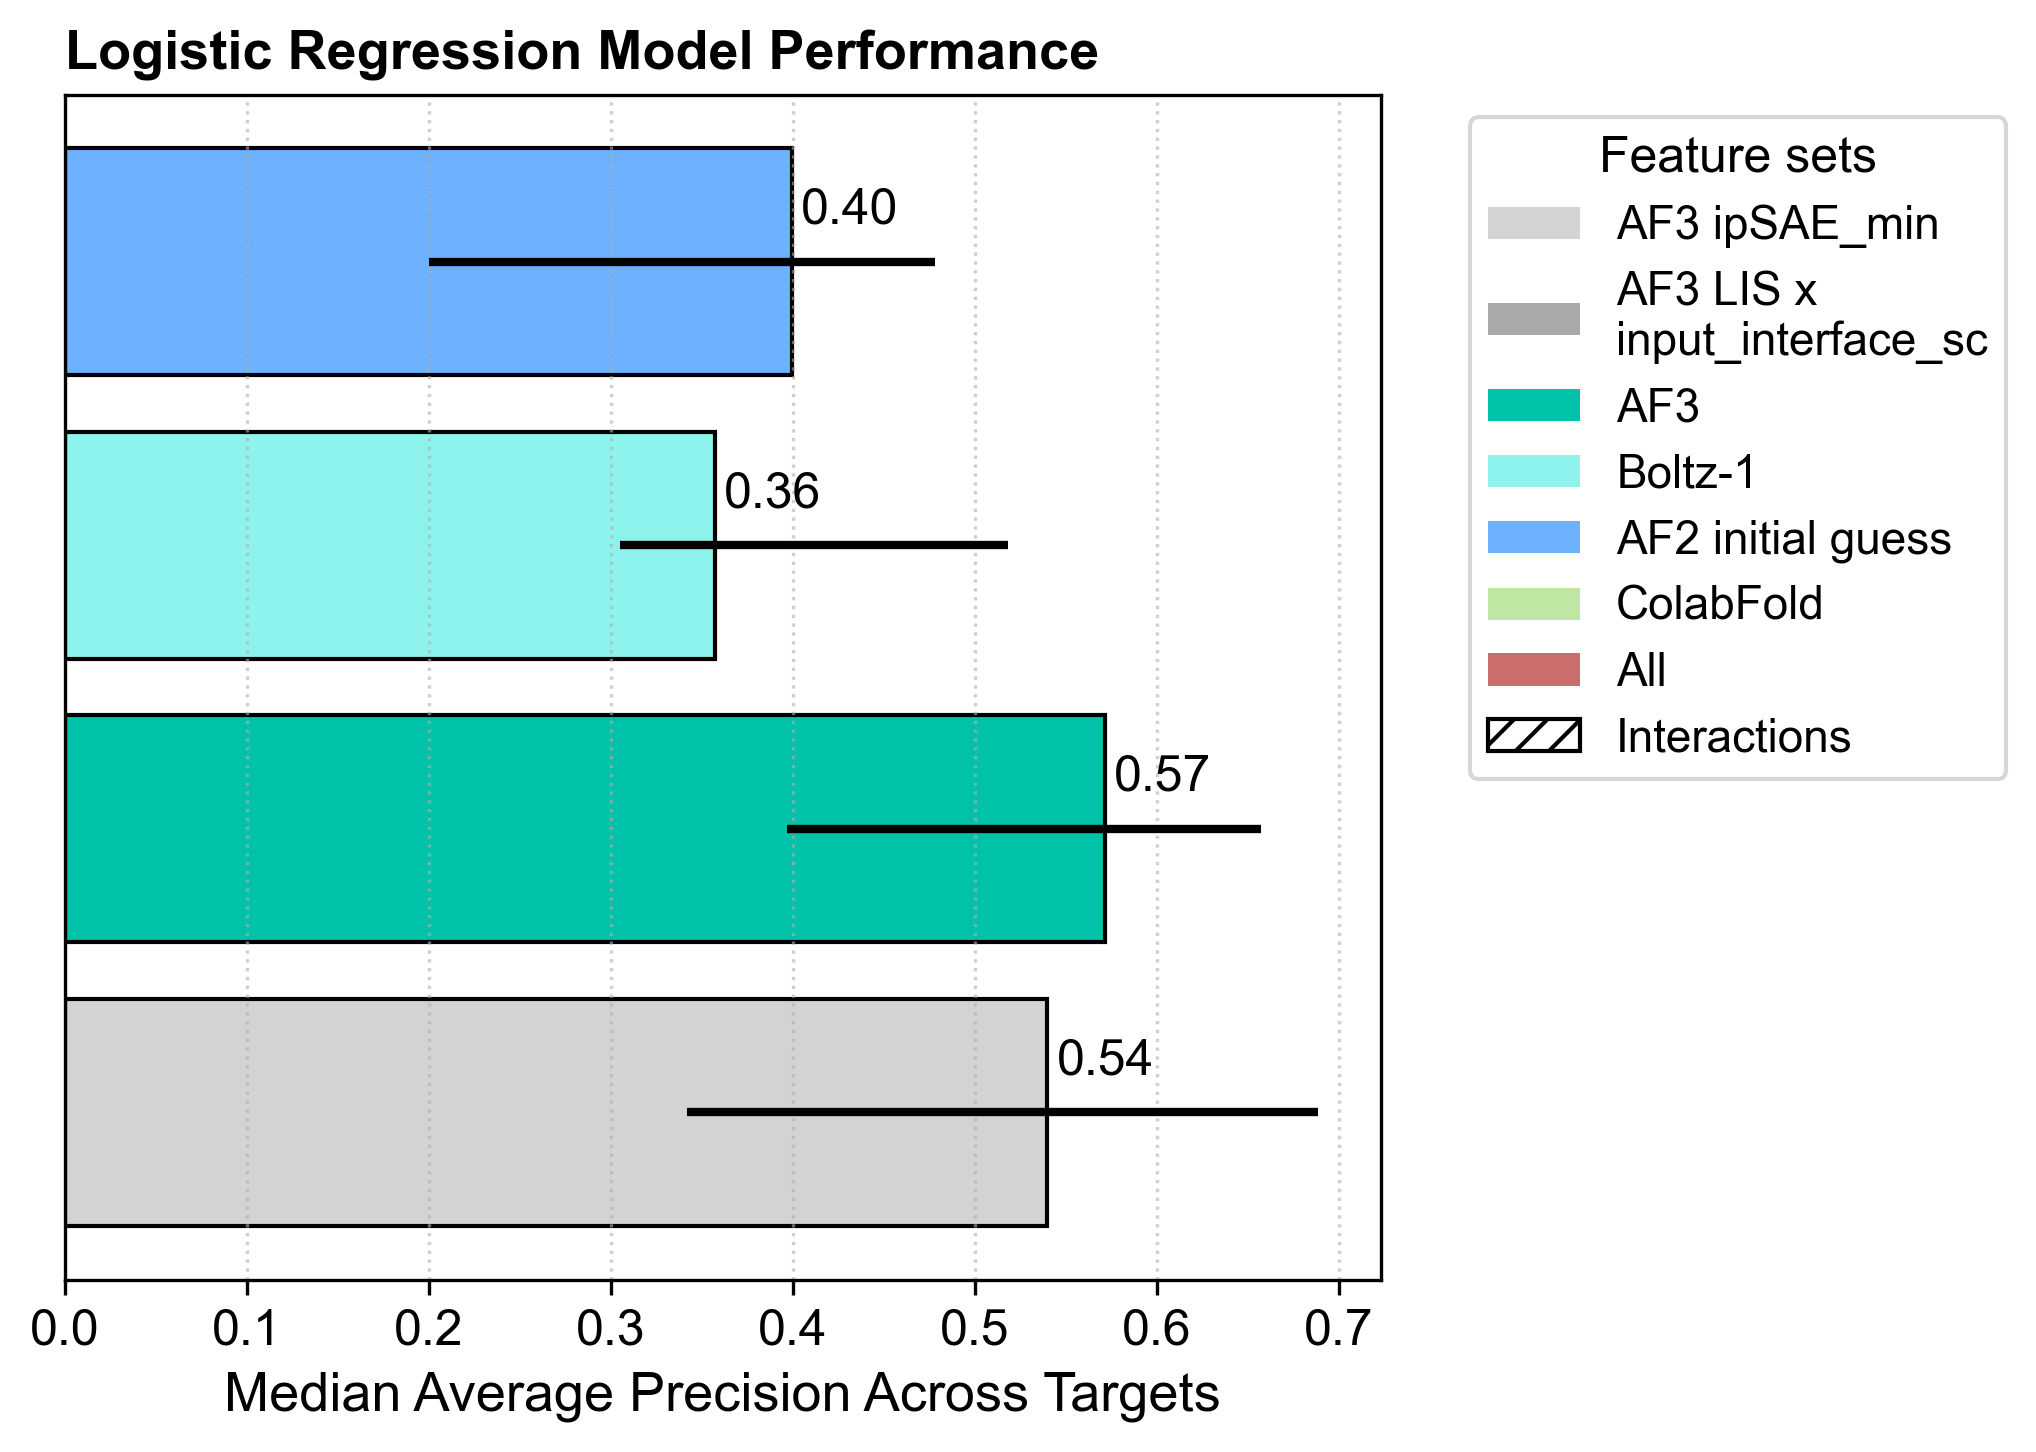

In [61]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path

# --- Settings ---
tags = ['af3', 'boltz1', 'af2','colab', 'all']
label_map = {
    'af3':    'AF3',
    'colab':  'ColabFold',
    'boltz1': 'Boltz-1',
    'af2':    'AF2 initial guess',
    'all':    'All'
}
color_map = {
    'AF2 initial guess': '#6db1ff',
    'ColabFold':         '#C0E6A4',
    'Boltz-1':           '#8EF3ED',
    'AF3':               '#00c2a8',
    'All':               '#C96E6D'
}
baseline_labels = {
    'single':      'AF3 ipSAE_min',
    'interaction': 'AF3 LIS x\ninput_interface_sc'
}
baseline_colors = {
    'single':      '#d3d3d3',
    'interaction': '#a9a9a9'
}

base_dir = Path("./data/lr_greedy_selection_outputs")

# --- Load baseline distributions ---
baseline_stats = {}
for key in ['single', 'interaction']:
    fname = base_dir / f"nested_greedy_{key}_af3.pkl"
    if not fname.exists(): continue
    with open(fname, "rb") as f:
        res = pickle.load(f)
    data = np.array([r['baseline_ap'] for r in res.values()
                     if 'baseline_ap' in r and not np.isnan(r['baseline_ap'])])
    q1, med, q3 = np.percentile(data, [25, 50, 75])
    baseline_stats[key] = {'median': med, 'q1': q1, 'q3': q3}

# --- Load model distributions ---
model_stats = {}
for tag in tags:
    for inter in [False, True]:
        mode = "interaction" if inter else "single"
        fname = base_dir / f"nested_greedy_{mode}_{tag}.pkl"
        if not fname.exists(): continue
        with open(fname, "rb") as f:
            res = pickle.load(f)
        data = np.array([r['greedy_ap'] for r in res.values()
                         if not np.isnan(r.get('greedy_ap', np.nan))])
        q1, med, q3 = np.percentile(data, [25, 50, 75])
        model_stats[(tag, inter)] = {'median': med, 'q1': q1, 'q3': q3}

# --- Assemble for plotting ---
labels, medians, q1s, q3s, colors, hatches = [], [], [], [], [], []

# Baselines
for key in ['single', 'interaction']:
    if key not in baseline_stats: continue
    stats = baseline_stats[key]
    labels.append(baseline_labels[key])
    medians.append(stats['median'])
    q1s.append(stats['q1'])
    q3s.append(stats['q3'])
    colors.append(baseline_colors[key])
    hatches.append('')

# Full models
for tag in tags:
    for inter in [False, True]:
        if (tag, inter) not in model_stats: continue
        stats = model_stats[(tag, inter)]
        labels.append(label_map[tag])
        medians.append(stats['median'])
        q1s.append(stats['q1'])
        q3s.append(stats['q3'])
        colors.append(color_map[label_map[tag]])
        hatches.append('' if not inter else '///')

# Compute asymmetric IQR errors
med_arr = np.array(medians)
q1_arr = np.array(q1s)
q3_arr = np.array(q3s)
lower_err = med_arr - q1_arr
upper_err = q3_arr - med_arr
xerr = np.vstack([lower_err, upper_err])

# --- Plot (unchanged except xerr) ---
fig, ax = plt.subplots(dpi=300, figsize=(7, 5))
y_pos = np.arange(len(labels))
bars = ax.barh(y_pos, medians, color=colors, xerr=xerr,
               error_kw={'capsize': 0, 'elinewidth': 2},
               edgecolor='black')
for bar, hatch in zip(bars, hatches):
    if hatch:
        bar.set_hatch(hatch)


ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('Median Average Precision Across Targets')

# Annotate bars
for bar, median in zip(bars, medians):
    ax.text(bar.get_width() + 0.005,
            bar.get_y() + bar.get_height()/2+ 0.18,
            f"{median:.2f}", va='center')

# Legend
legend_handles = [
    Patch(facecolor=baseline_colors['single'], label=baseline_labels['single']),
    Patch(facecolor=baseline_colors['interaction'], label=baseline_labels['interaction'])
]
for tag in tags:
    legend_handles.append(Patch(facecolor=color_map[label_map[tag]],
                                label=label_map[tag]))
legend_handles.append(Patch(facecolor='white', hatch='///',
                            edgecolor='black', label='Interactions'))

ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1),
          loc='upper left', title="Feature sets")
ax.set_title('Logistic Regression Model Performance',
             loc='left', fontweight='bold')
ax.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

## Best Model per Target

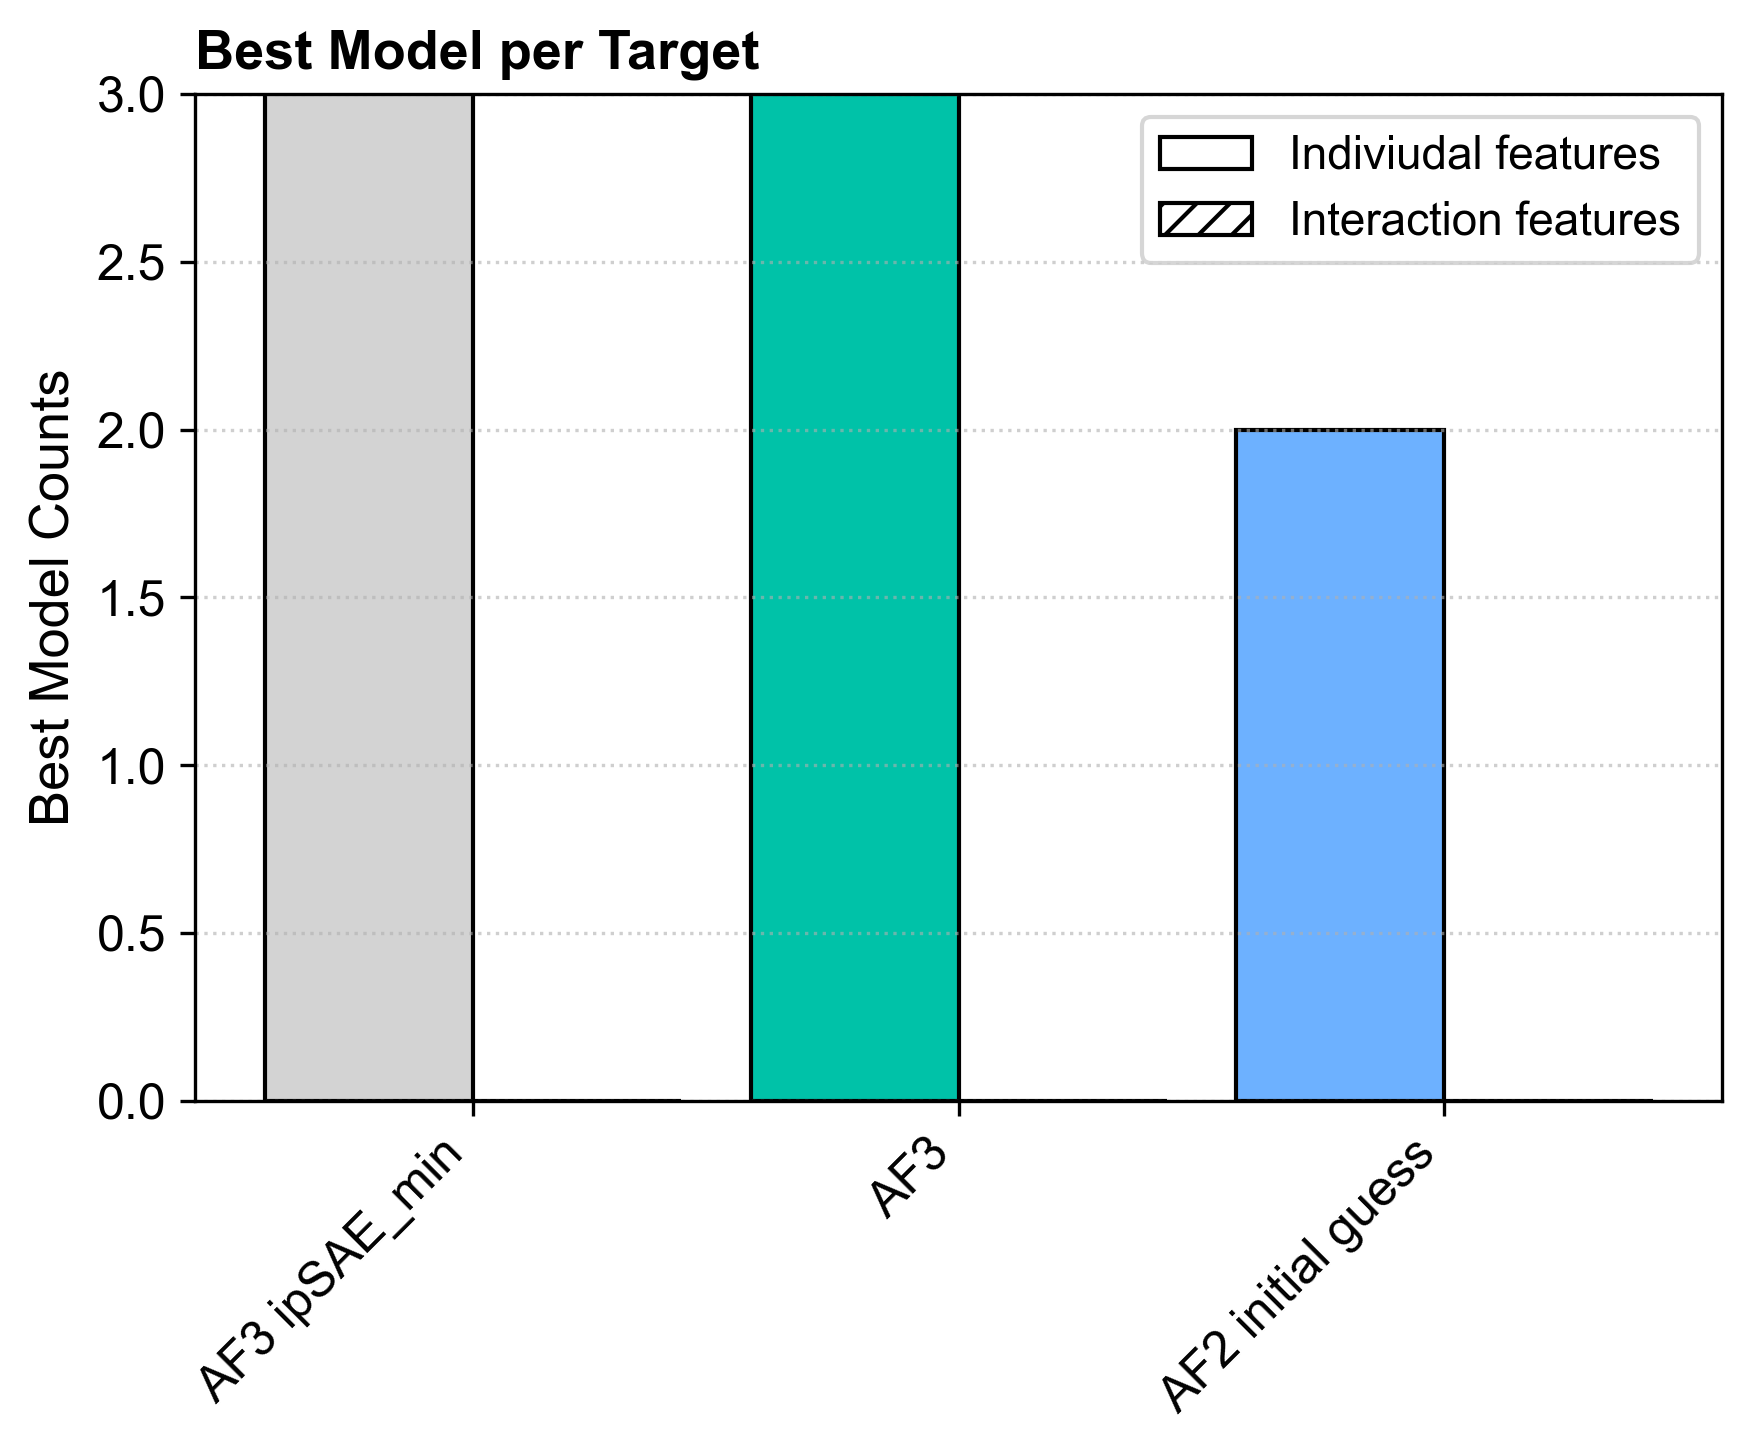

In [56]:
# --- 1) Gather per-target APs ---
all_scores = defaultdict(dict)

# Baseline APs
for mode in ['single', 'interaction']:
    fname = base_dir / f"nested_greedy_{mode}_af3.pkl"
    if not fname.exists():
        continue
    with open(fname, 'rb') as f:
        res = pickle.load(f)
    lbl = baseline_labels[mode]
    for tgt, r in res.items():
        ap = r.get('baseline_ap', np.nan)
        if not np.isnan(ap):
            all_scores[tgt][lbl] = ap

# Greedy model APs
for tag in tags:
    for inter in (False, True):
        mode = 'interaction' if inter else 'single'
        fname = base_dir / f"nested_greedy_{mode}_{tag}.pkl"
        if not fname.exists():
            continue
        with open(fname, 'rb') as f:
            res = pickle.load(f)
        lbl = label_map[tag] + (' (inter)' if inter else '')
        for tgt, r in res.items():
            ap = r.get('greedy_ap', np.nan)
            if not np.isnan(ap):
                all_scores[tgt][lbl] = ap

method_best_counts = defaultdict(int)
for tgt, scores in all_scores.items():
    if not scores:
        continue

    # find the maximum AP for this target
    max_ap = max(scores.values())

    # find all methods that achieve max_ap
    winners = [lbl for lbl, ap in scores.items() if np.isclose(ap, max_ap)]

    # only count if there is exactly one winner
    if len(winners) == 1:
        method_best_counts[winners[0]] += 1

# --- 3) Prepare grouped bar data ---
# Define groups in plotting order
groups = [
    baseline_labels['single'],
    baseline_labels['interaction']
] + list(label_map.values())

# Extract counts for single vs. interaction per group
single_counts = [method_best_counts.get(g, 0) for g in groups]
inter_counts = [method_best_counts.get(f"{g} (inter)", 0) for g in groups]
# Filter out groups with zero for both
mask = [(s + i) > 0 for s, i in zip(single_counts, inter_counts)]
groups_f = [g for g, m in zip(groups, mask) if m]
single_counts_f = [s for s, m in zip(single_counts, mask) if m]
inter_counts_f = [i for i, m in zip(inter_counts, mask) if m]

single_colors_f = []
inter_colors_f = []
for g in groups_f:
    if g == baseline_labels['single']:
        # single‐baseline bar
        single_colors_f.append(baseline_colors['single'])
        # its partner “interaction” bar (always zero height) still gets the interaction grey
        inter_colors_f.append(baseline_colors['interaction'])
    elif g == baseline_labels['interaction']:
        # interaction‐baseline bar
        single_colors_f.append(baseline_colors['interaction'])
        inter_colors_f.append(baseline_colors['interaction'])
    else:
        # any other model name
        single_colors_f.append(color_map.get(g, '#d3d3d3'))
        inter_colors_f.append(color_map.get(g, '#a9a9a9'))

# --- Plot ---
group_sep = 0.7
x = np.arange(len(groups_f)) * group_sep
width = 0.3

fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
bars1 = ax.bar(x - width/2, single_counts_f, width, label='Individual', color=single_colors_f,edgecolor='black')
bars2 = ax.bar(x + width/2, inter_counts_f, width, label='Interaction',edgecolor='black',
               color=inter_colors_f, hatch='///')

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels(groups_f, rotation=45, ha='right')
ax.set_ylabel('Best Model Counts')
ax.set_title('Best Model per Target', loc='left', fontweight='bold')

# Legend
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Indiviudal features'),
    Patch(facecolor='white', edgecolor='black', hatch='///', label='Interaction features')
]
ax.legend(handles=legend_elements, loc='best')
ax.set_ylim(0,3)

# Grid
ax.grid(axis='y', linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

## #Features per Model

Skipping data/lr_greedy_selection_outputs/nested_greedy_interaction_af2.pkl: [Errno 2] No such file or directory: 'data/lr_greedy_selection_outputs/nested_greedy_interaction_af2.pkl'
Skipping data/lr_greedy_selection_outputs/nested_greedy_single_colab.pkl: [Errno 2] No such file or directory: 'data/lr_greedy_selection_outputs/nested_greedy_single_colab.pkl'
Skipping data/lr_greedy_selection_outputs/nested_greedy_interaction_colab.pkl: [Errno 2] No such file or directory: 'data/lr_greedy_selection_outputs/nested_greedy_interaction_colab.pkl'
Skipping data/lr_greedy_selection_outputs/nested_greedy_interaction_boltz1.pkl: [Errno 2] No such file or directory: 'data/lr_greedy_selection_outputs/nested_greedy_interaction_boltz1.pkl'
Skipping data/lr_greedy_selection_outputs/nested_greedy_interaction_af3.pkl: [Errno 2] No such file or directory: 'data/lr_greedy_selection_outputs/nested_greedy_interaction_af3.pkl'
Skipping data/lr_greedy_selection_outputs/nested_greedy_single_all.pkl: [Errno 2]

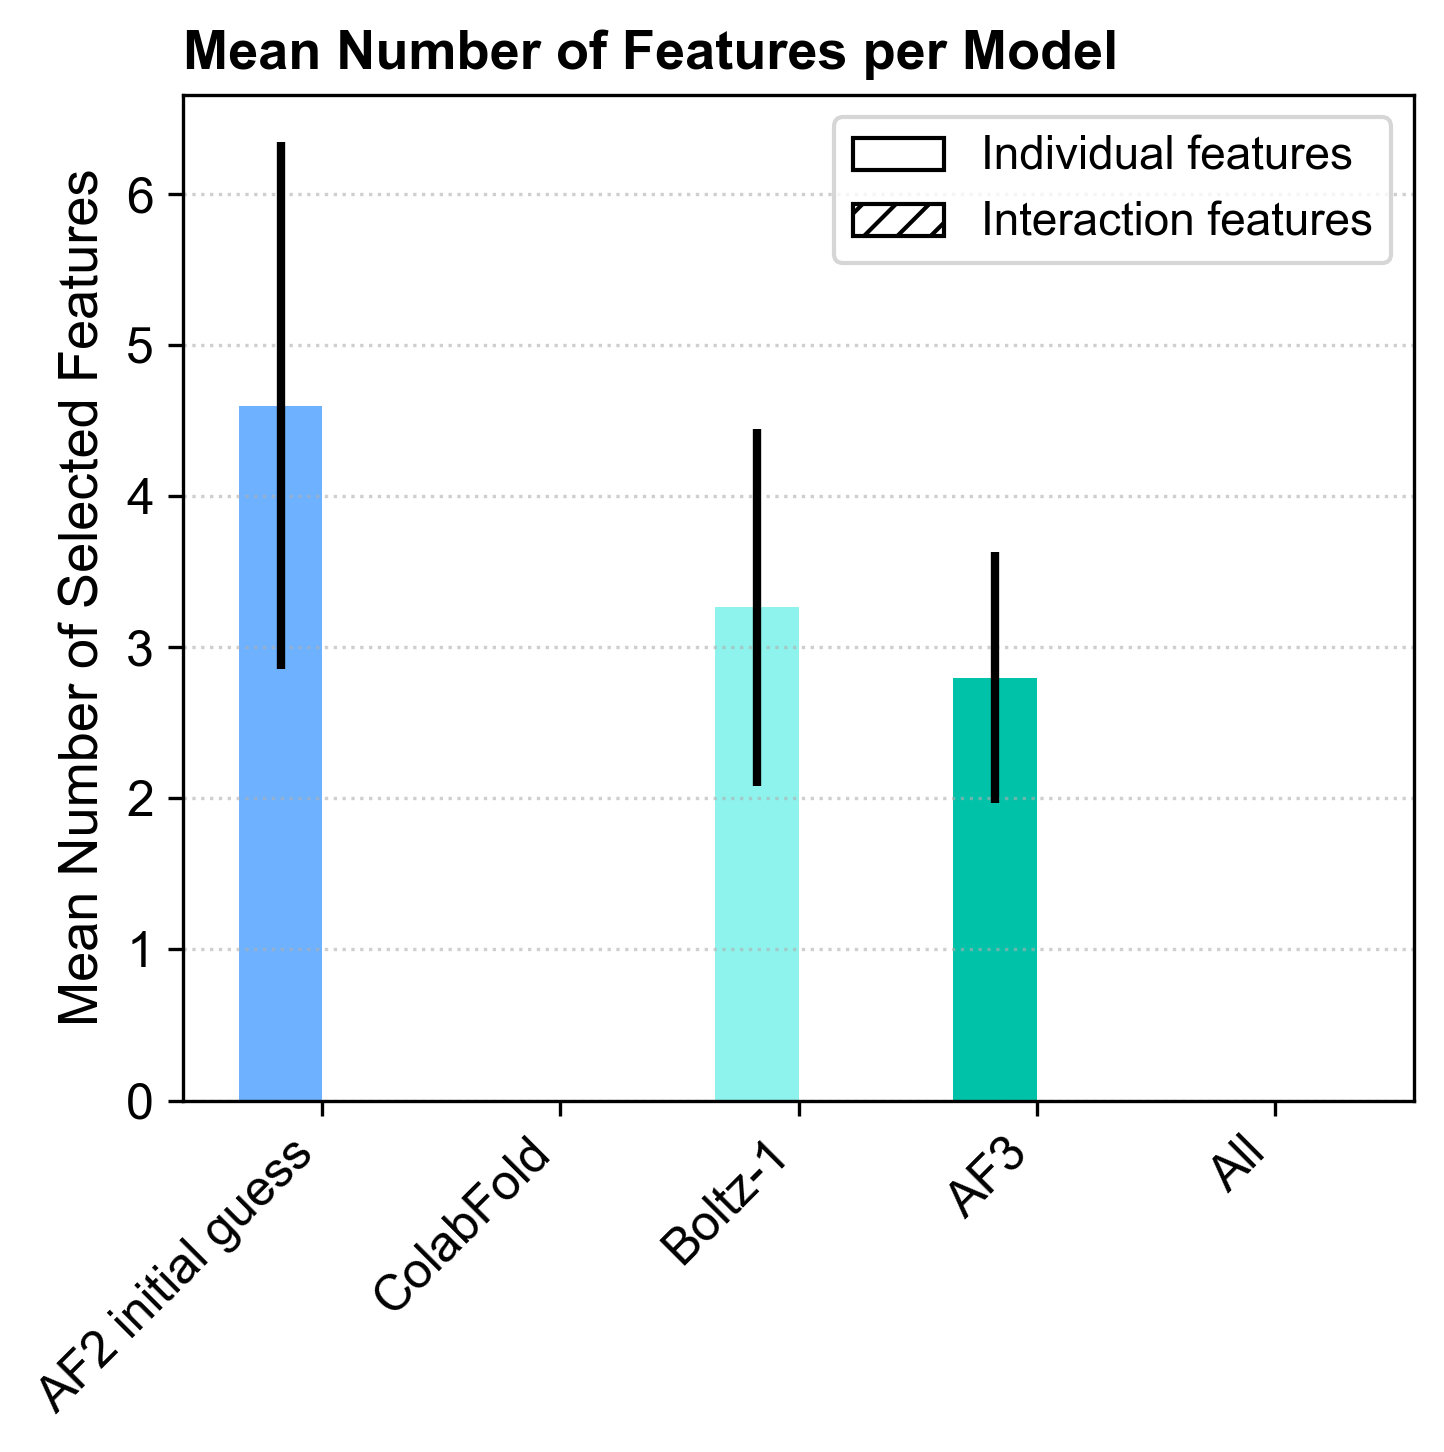

In [62]:
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from typing import Tuple

# --- Config --------------------------------------------------
tags = ['af2', 'colab', 'boltz1', 'af3', 'all']
label_map = {
    'af2':    'AF2 initial guess',
    'colab':  'ColabFold',
    'boltz1': 'Boltz-1',
    'af3':    'AF3',
    'all':    'All'
}
color_map = {
    'AF2 initial guess': '#6db1ff',
    'ColabFold':         '#C0E6A4',
    'Boltz-1':           '#8EF3ED',
    'AF3':               '#00c2a8',
    'All':               '#C96E6D'
}

def load_feature_stats(tag: str, inter: bool) -> Tuple[float, float]:
    """Load pickled results and return (mean_count, std_count) from greedy selection results."""
    mode = 'interaction' if inter else 'single'
    fn = Path(".") / "data" / "lr_greedy_selection_outputs" / f"nested_greedy_{mode}_{tag}.pkl"
    try:
        with open(fn, 'rb') as f:
            res = pickle.load(f)
    except (FileNotFoundError, pickle.UnpicklingError) as e:
        print(f"Skipping {fn}: {e}")
        return 0.0, 0.0

    counts = [len(r['greedy_selected']) for r in res.values() if 'greedy_selected' in r and r['greedy_selected']]
    if not counts:
        return 0.0, 0.0

    return float(np.mean(counts)), float(np.std(counts))

# --- Gather stats -------------------------------------------
means_no, stds_no = [], []
means_in, stds_in = [], []

for tag in tags:
    m, s = load_feature_stats(tag, inter=False)
    means_no.append(m)
    stds_no.append(s)

    m, s = load_feature_stats(tag, inter=True)
    means_in.append(m)
    stds_in.append(s)

# --- Plot ----------------------------------------------------
x = np.arange(len(tags))
width = 0.35
fig, ax = plt.subplots(figsize=(5, 5),dpi=300)

bars_no = ax.bar(
    x - width/2,
    means_no,
    width,
    yerr=stds_no,
    error_kw={'capsize': 0, 'elinewidth': 2},
    color=[color_map[label_map[t]] for t in tags],
    label='Individual'
)

bars_in = ax.bar(
    x + width/2,
    means_in,
    width,
    yerr=stds_in,
    error_kw={'capsize': 0, 'elinewidth': 2},
    color=[color_map[label_map[t]] for t in tags],
    hatch='///',
    label='Interaction'
)

# Labels & legend
ax.set_xticks(x)
ax.set_xticklabels([label_map[t] for t in tags], rotation=45, ha='right')
ax.set_ylabel('Mean Number of Selected Features')
ax.grid(axis='y', linestyle=':', alpha=0.6)
ax.set_title('Mean Number of Features per Model', loc='left', fontweight='bold')

# Separate legends
tag_handles = [Patch(facecolor=color_map[label_map[t]], label=label_map[t]) for t in tags]
hatch_handles = [
    Patch(facecolor='white', edgecolor='black', label='Individual features'),
    Patch(facecolor='white', hatch='///', edgecolor='black', label='Interaction features')
]
leg2 = ax.legend(handles=hatch_handles, loc='upper right')

plt.tight_layout()
plt.show()

# XGBoost model analysis

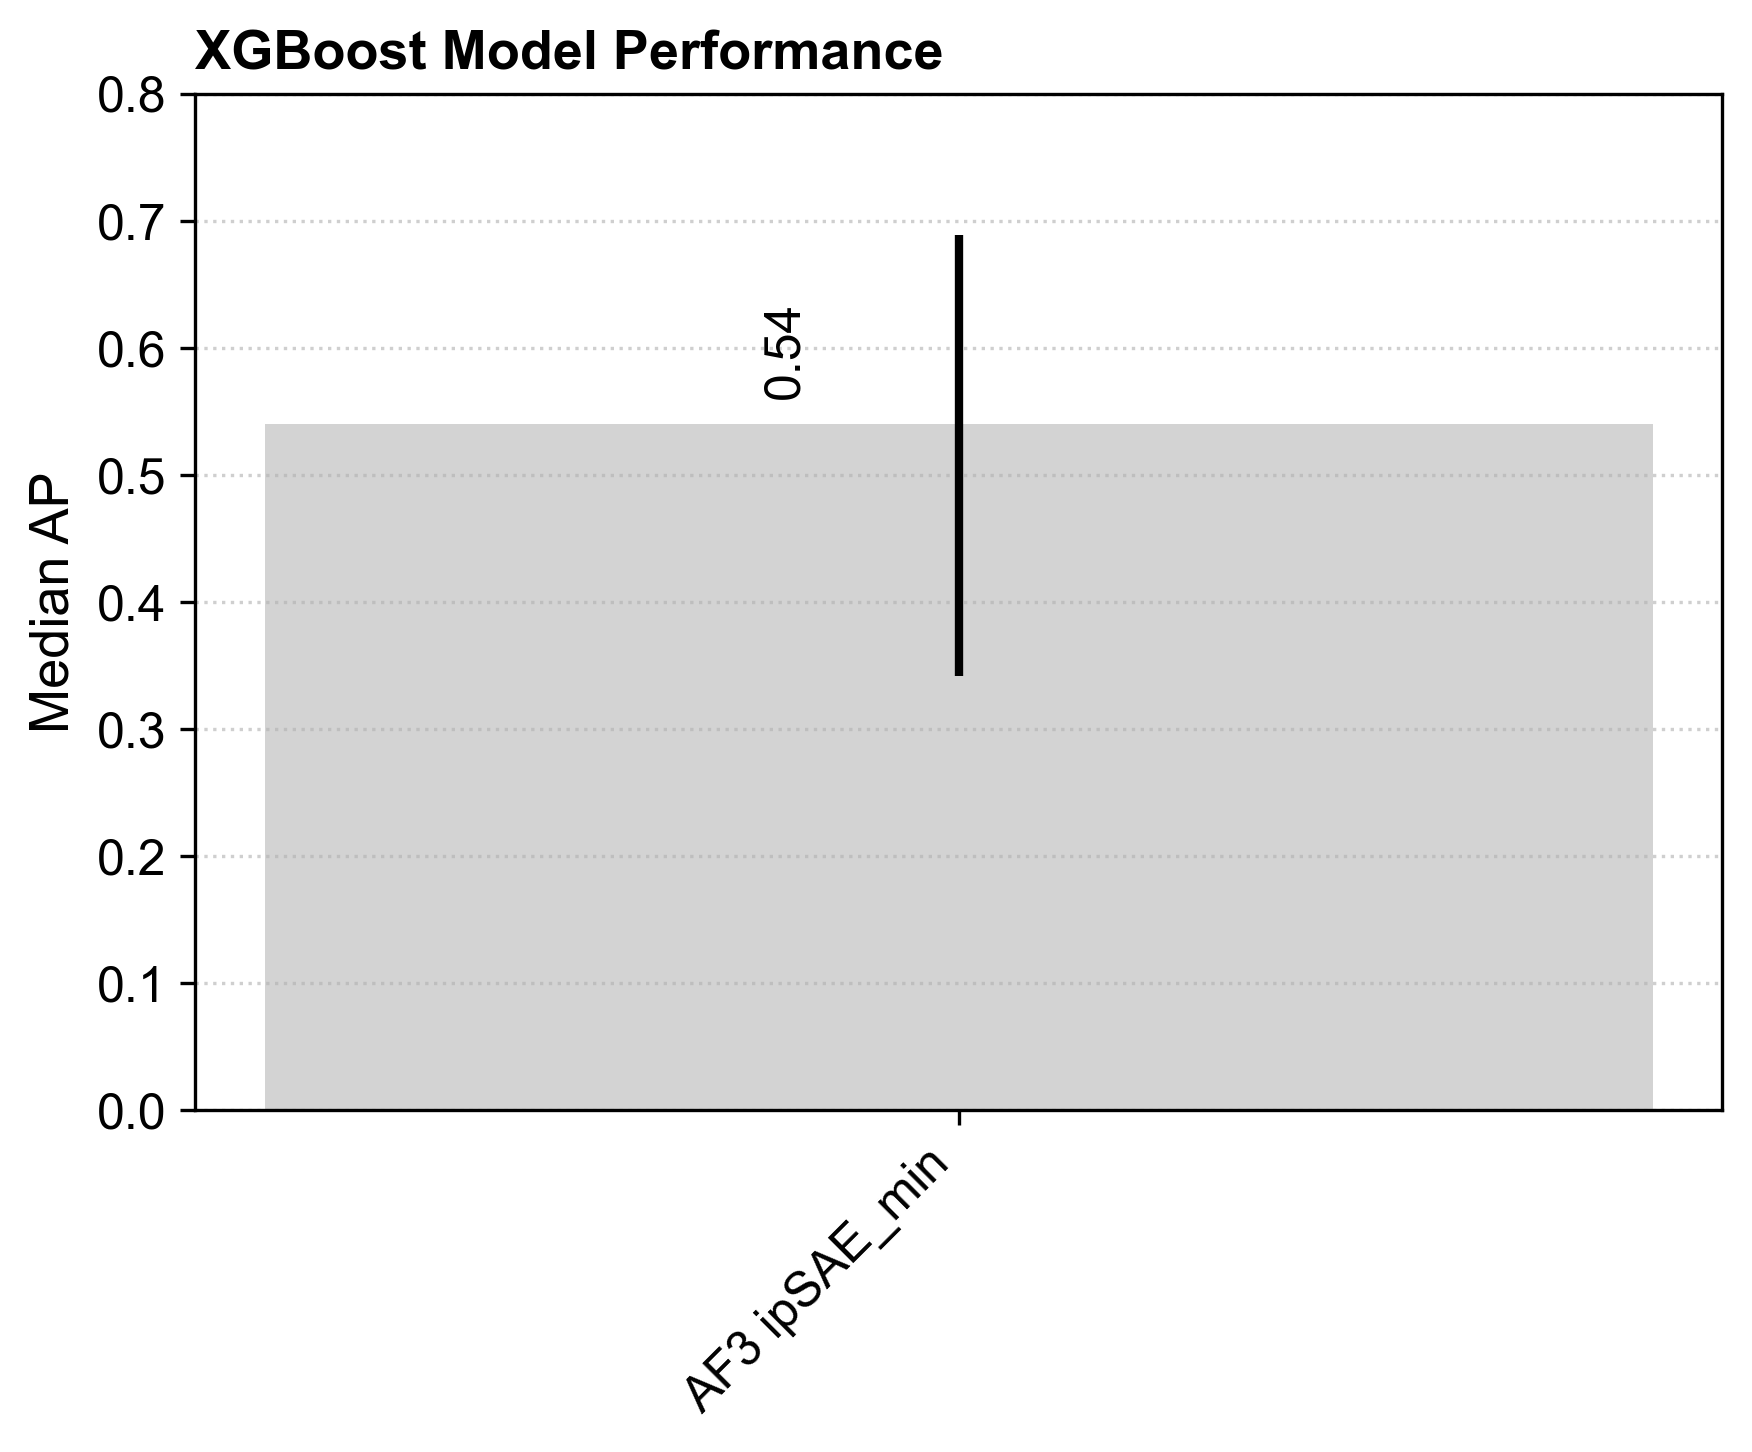

In [63]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path

# --- Settings (unchanged) ---
tags = ['af3', 'boltz1', 'af2', 'colab', 'all']
label_map = {
    'af2':    'AF2 initial guess',
    'colab':  'ColabFold',
    'boltz1': 'Boltz-1',
    'af3':    'AF3',
    'all':    'All'
}
color_map = {
    'AF2 initial guess': '#6db1ff',
    'ColabFold':         '#C0E6A4',
    'Boltz-1':           '#8EF3ED',
    'AF3':               '#00c2a8',
    'All':               '#C96E6D'
}
baseline_labels = {
    'single':      'AF3 ipSAE_min',
    'interaction': 'AF3 LIS x\ninput_interface_sc'
}
baseline_colors = {
    'single':      '#d3d3d3',
    'interaction': '#a9a9a9'
}

base_dir = Path("./data/lr_greedy_selection_outputs")

# --- Load baseline APs and compute median, Q1, Q3 ---
baseline_vals = {}
for key in ['single', 'interaction']:
    fname = base_dir / f"nested_greedy_{key}_af3.pkl"
    if not fname.exists():
        continue
    with open(fname, "rb") as f:
        res = pickle.load(f)
    data = np.array([
        r['baseline_ap']
        for r in res.values()
        if 'baseline_ap' in r and not np.isnan(r['baseline_ap'])
    ])
    q1, med, q3 = np.percentile(data, [25, 50, 75])
    baseline_vals[key] = {'median': med, 'q1': q1, 'q3': q3}

# --- Load XGBoost APs and compute median, Q1, Q3 ---
xgb_dir = Path("./data/xgboost_outputs")
model_vals = {}
for tag in tags:
    fname = xgb_dir / f"{tag}_xgb_results.pkl"
    if not fname.exists():
        continue
    with open(fname, "rb") as f:
        results = pickle.load(f)
    data = np.array([
        v['ap']
        for v in results.values()
        if 'ap' in v and not np.isnan(v['ap'])
    ])
    if data.size == 0:
        continue
    q1, med, q3 = np.percentile(data, [25, 50, 75])
    model_vals[tag] = {'median': med, 'q1': q1, 'q3': q3}

# --- Assemble data for plotting ---
labels, medians, q1s, q3s, colors, hatches = [], [], [], [], [], []

# Baselines
for key in ['single', 'interaction']:
    if key not in baseline_vals:
        continue
    stats = baseline_vals[key]
    labels.append(baseline_labels[key])
    medians.append(stats['median'])
    q1s.append(stats['q1'])
    q3s.append(stats['q3'])
    colors.append(baseline_colors[key])
    hatches.append('')

# XGBoost models
for tag in tags:
    if tag not in model_vals:
        continue
    stats = model_vals[tag]
    labels.append(label_map[tag])
    medians.append(stats['median'])
    q1s.append(stats['q1'])
    q3s.append(stats['q3'])
    colors.append(color_map[label_map[tag]])
    hatches.append('')  # no hatch here

# Compute asymmetric error bars
med = np.array(medians)
lower_err = med - np.array(q1s)
upper_err = np.array(q3s) - med
yerr = np.vstack([lower_err, upper_err])

# --- Plot (vertical bars) ---
fig, ax = plt.subplots(dpi=300, figsize=(6, 5))
x_pos = np.arange(len(labels))
bars = ax.bar(
    x_pos, medians,
    color=colors,
    yerr=yerr,
    error_kw={'capsize': 0, 'elinewidth': 2},
)

# Apply hatches
for bar, hatch in zip(bars, hatches):
    if hatch:
        bar.set_hatch(hatch)

# Format
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Median AP')
ax.set_ylim(0, 0.8)
ax.grid(axis='y', linestyle=':', alpha=0.6)

# Annotate medians
for bar, median in zip(bars, medians):
    ax.text(
        bar.get_x() + bar.get_width() / 2 - 0.1,
        bar.get_height() + 0.02,
        f"{median:.2f}",
        ha='center', va='bottom', rotation=90
    )

# Title and layout
ax.set_title('XGBoost Model Performance', loc='left', fontweight='bold')
plt.tight_layout()
plt.show()

# AF3 individual features model analysis

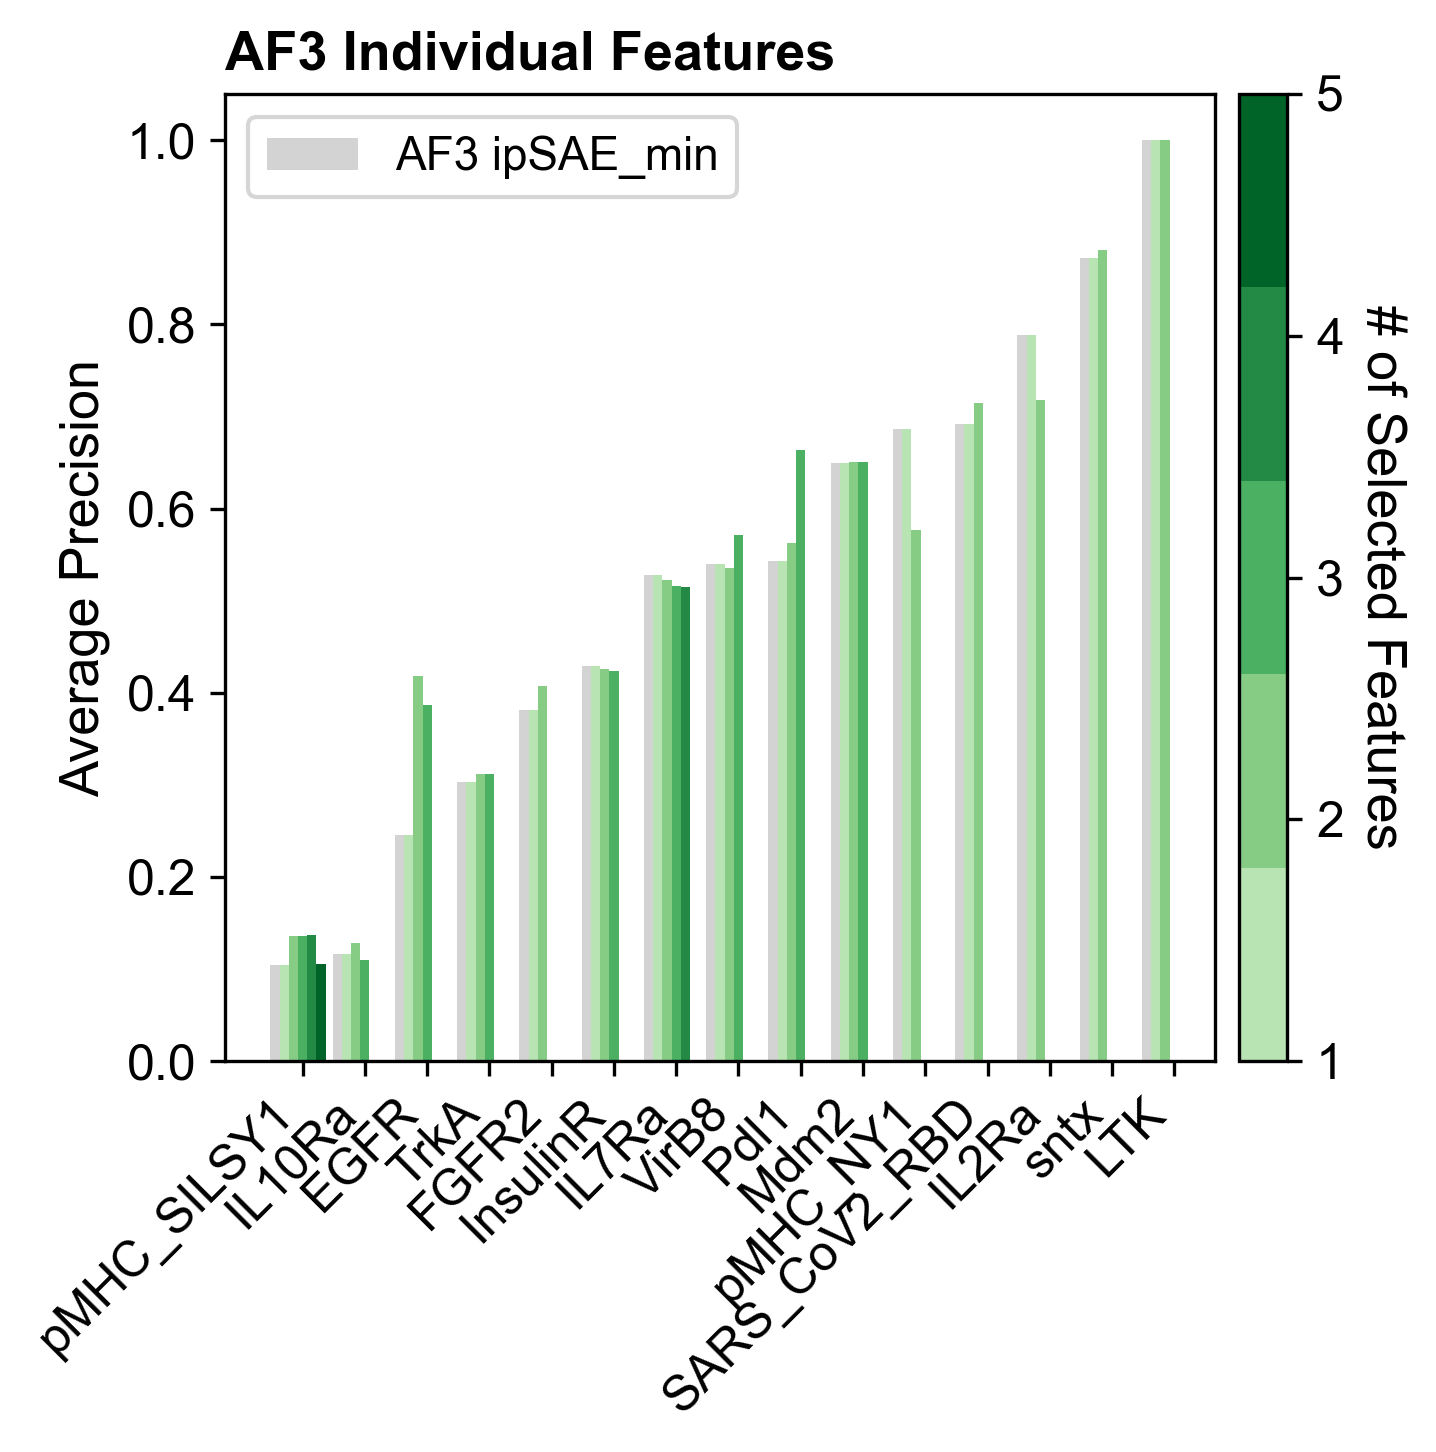

In [39]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from matplotlib.patches import Patch
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

# --- Load Results ---
base_dir = Path("./data/lr_greedy_selection_outputs")
with open(base_dir / "nested_greedy_single_af3.pkl", "rb") as f:
    res_single = pickle.load(f)

# --- Sort targets by baseline AP ---
sorted_targets = sorted(
    res_single.keys(),
    key=lambda t: res_single[t]['baseline_ap']
)

# --- Extract outer‐AP series per target ---
def extract_ap_series(res, targets):
    ap_by_target, max_steps = {}, 0
    for t in targets:
        r          = res[t]
        baseline   = r['baseline_ap']
        otrack     = r.get('greedy_outer_track', [])
        series     = [baseline] + [ap for (_, ap) in otrack]
        ap_by_target[t] = series
        max_steps = max(max_steps, len(series))
    return ap_by_target, max_steps

aps_single, max_steps = extract_ap_series(res_single, sorted_targets)

# --- Compute bar widths for fixed group width ---
group_width   = 0.8
bar_width     = group_width / max_steps
group_spacing = group_width + 0.1
x_centers     = np.arange(len(sorted_targets)) * group_spacing

# --- Set up plot ---
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

# --- Color map for steps (skip step 0 = baseline) ---
n_steps   = max_steps - 1
vals      = np.linspace(0.3, 0.9, n_steps)
step_cols = [plt.cm.Greens(v) for v in vals]
cmap_lim  = LinearSegmentedColormap.from_list("Greens_lim", step_cols, N=n_steps)
norm      = Normalize(vmin=1, vmax=n_steps)

# --- Plot each step as a bar within each group ---
for step in range(max_steps):
    heights = [
        aps_single[t][step] if step < len(aps_single[t]) else np.nan
        for t in sorted_targets
    ]
    color = '#d3d3d3' if step == 0 else step_cols[step - 1]
    ax.bar(x_centers + step * bar_width, heights, bar_width, color=color)

# --- Formatting ---
ax.set_xticks(x_centers + group_width / 2)
ax.set_xticklabels(sorted_targets, rotation=45, ha='right')
ax.set_ylabel("Average Precision")
ax.set_ylim(0, 1.05)
ax.set_title("AF3 Individual Features", fontweight='bold', loc='left')
#ax.grid(axis='y', linestyle=':', alpha=0.6)

# --- Legend for baseline only ---
ax.legend([Patch(facecolor='#d3d3d3')], ["AF3 ipSAE_min"], loc='upper left')

# Automatic colorbar for number of selected features, with integer ticks
sm = ScalarMappable(cmap=cmap_lim, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("# of Selected Features", rotation=270, labelpad=15)

# force ticks at every integer from 1 through n_steps
cbar.set_ticks(np.arange(1, n_steps+1, 1))

plt.tight_layout()
plt.show()


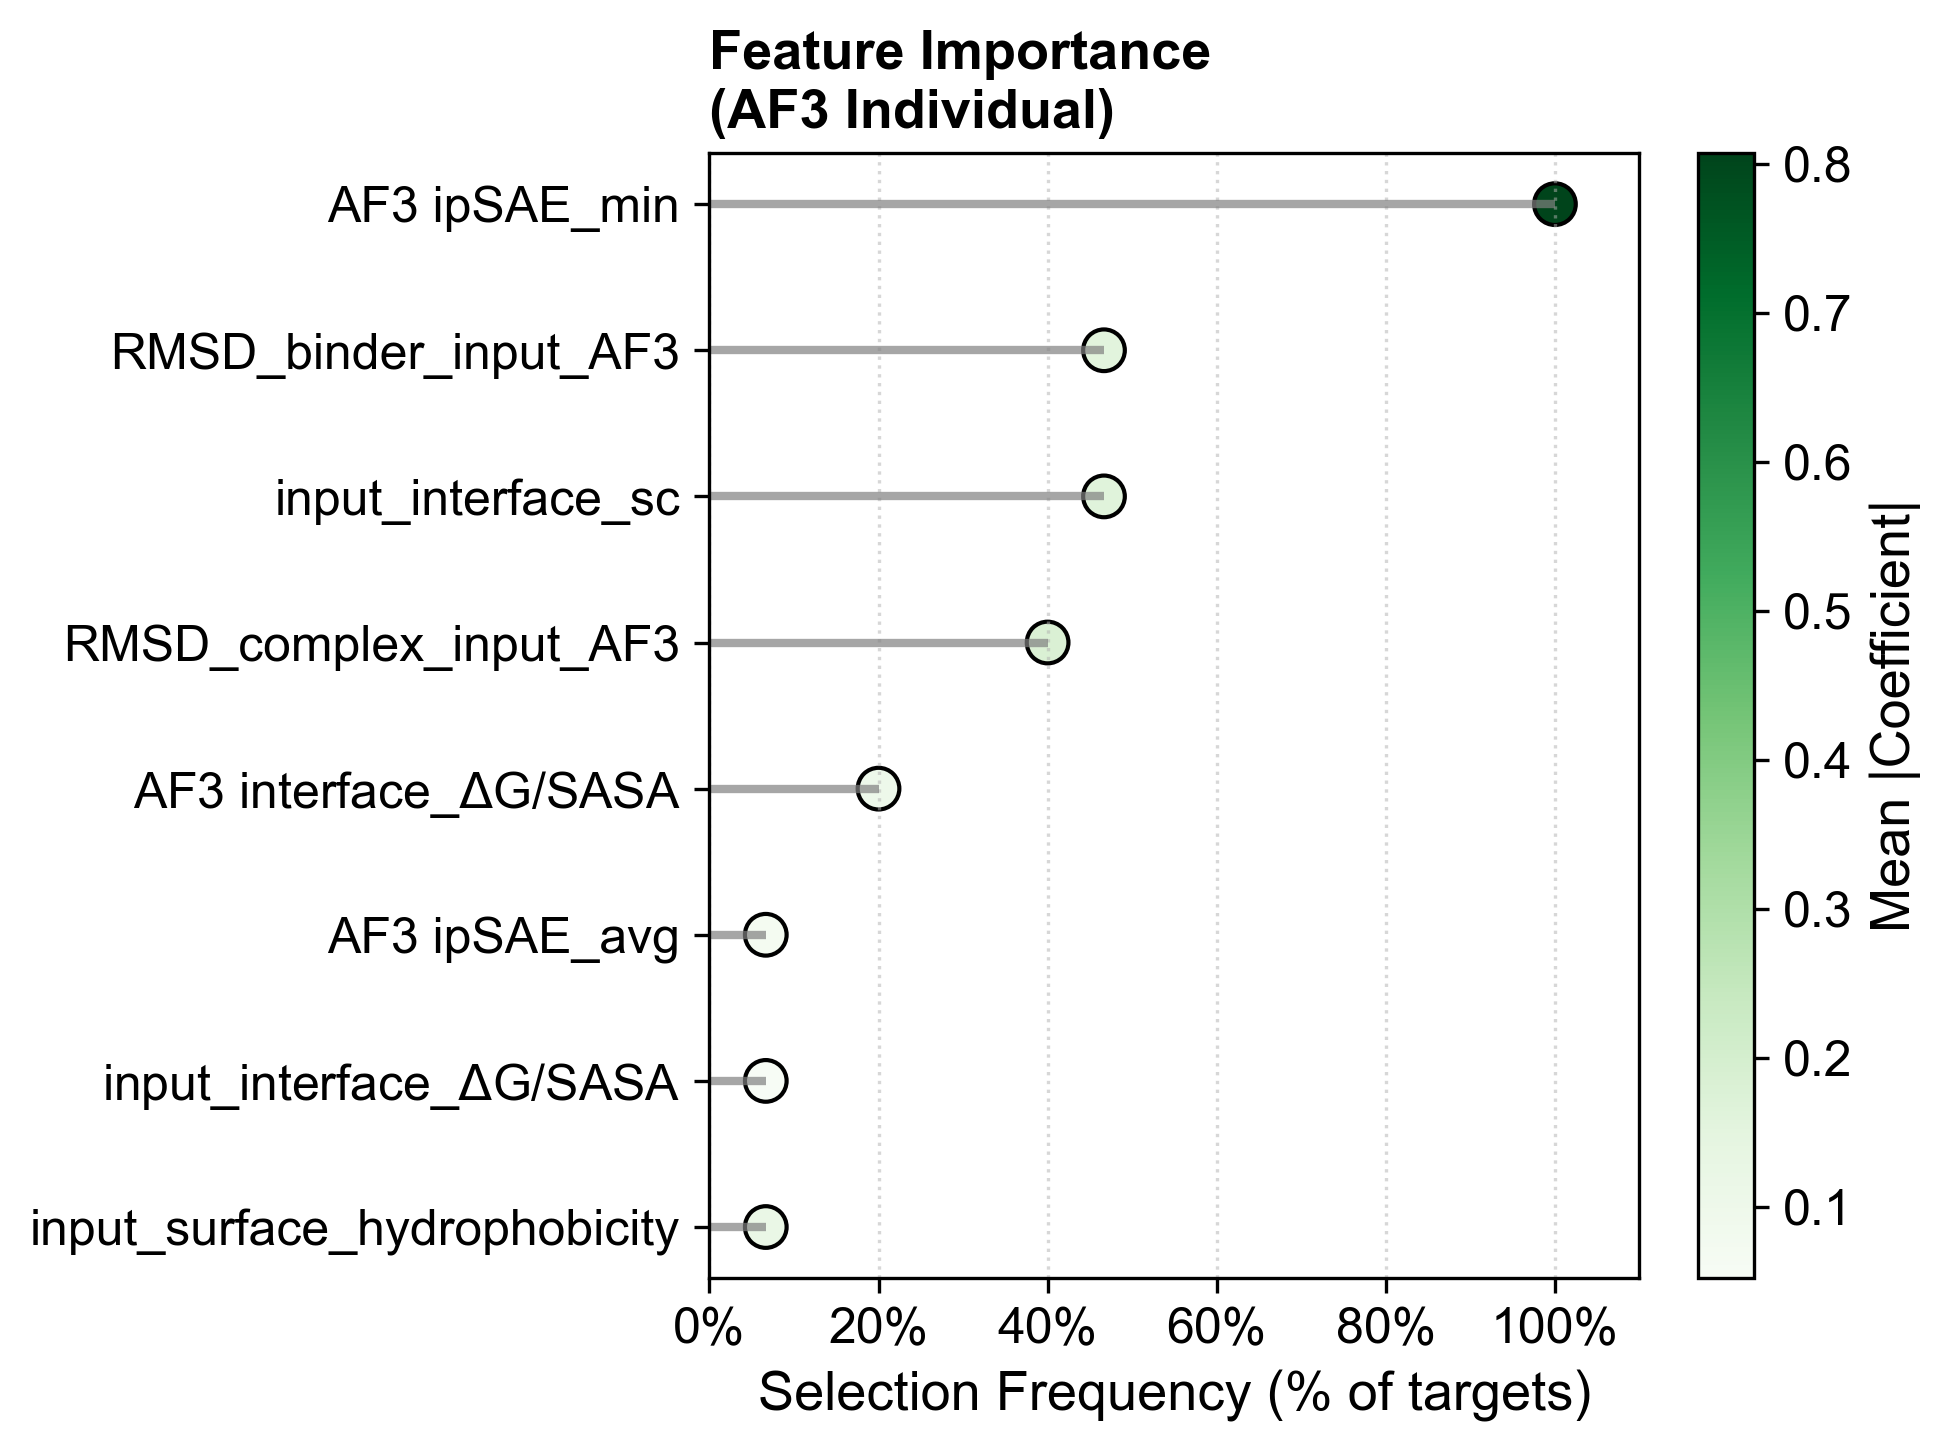

In [64]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import cm
from pathlib import Path

# --- SETTINGS ---
tag = 'af3'
mode = 'single'  # 'single', 'interaction', etc.
title = 'Feature Importance\n(AF3 Individual)'

path = f'./data/lr_greedy_selection_outputs/nested_greedy_{mode}_{tag}.pkl'

n_feats = 8  # how many top features to plot
# --- Prettify Feature Names ---
def prettify_feature_name(f):
    f = f.replace('colab_af3', 'ColabFold_AF3')
    f = f.replace('af2_af3', 'AF2_AF3')
    f = f.replace('_af3', '_AF3')
    f = f.replace('input_pymol_percent_nonpolar', 'pymol_nonpolar%_input')
    f = f.replace('input_pymol_percent_nonpolar', 'pymol_nonpolar%_input')
    f = f.replace('RMSD_chA_aft_chB_align_input_AF3', 'RMSD_binder_input_AF3')
    f = f.replace('af3_', 'AF3 ').replace('af2_', 'AF2 ')
    f = f.replace('colab_', 'ColabFold ').replace('boltz1_', 'Boltz-1 ')
    f = f.replace('rosetta_', '').replace('rosetta', '')
    f = f.replace('*', ' × ')
    f = f.replace('dG_SASA_ratio', r'$\Delta$G/SASA')
    f = f.replace('dSAP_dSASA_ratio', r'$\Delta$SAP/SASA')
    f = f.replace('dG', r'$\Delta$G')
    f = f.replace('sap_delta', r'$\Delta$SAP')
    f = f.replace('dockQ', 'DockQ')
    return f

# --- Load Results ---
with open(path, 'rb') as f:
    res = pickle.load(f)

# --- Build Coefficient DataFrame ---
all_feats = sorted({feat for r in res.values() for feat in r['greedy_coefficients']})
df_w = pd.DataFrame(0.0, index=res.keys(), columns=all_feats)
for tgt, r in res.items():
    for feat, w in r['greedy_coefficients'].items():
        df_w.at[tgt, feat] = w

# --- Summaries ---
sel_freq = (df_w != 0).sum(axis=0)
mean_abs = df_w.replace(0, np.nan).mean(axis=0).abs()
summary = pd.DataFrame({'freq': sel_freq, 'mean_abs_coef': mean_abs})

# --- Select Top N ---
top_feats = summary.sort_values('freq', ascending=False).head(n_feats)
features = [prettify_feature_name(f) for f in top_feats.index]
freq_vals = top_feats['freq'].values
coef_vals = top_feats['mean_abs_coef'].values
frac_vals = freq_vals / df_w.shape[0]

# --- Color Gradient ---
norm = coef_vals / coef_vals.max()
colors = cm.Blues(0.3 + 0.7 * norm)

# --- Plot ---
fig, ax = plt.subplots(figsize=(6.5, 5),dpi=300)
y = np.arange(len(features))

# Lines (sticks)
for xi, yi in zip(frac_vals, y):
    ax.hlines(yi, 0, xi, color='gray', alpha=0.7, linewidth=2)

# Circles (heads)
sc = ax.scatter(frac_vals, y, s=100, c=coef_vals, cmap='Greens', edgecolor='k')

# Formatting
ax.set_yticks(y)
ax.set_xlim(0,1.1)
ax.set_yticklabels(features)
ax.invert_yaxis()
ax.set_xlabel('Selection Frequency (% of targets)')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_title(title,loc='left',fontweight='bold')
# Colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Mean |Coefficient|')

ax.grid(axis='x', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# AF3 ipSAE_min + RMSD binder + input_interface_sc retraining

In [41]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.metrics import (
    precision_recall_curve,
    precision_score,
    f1_score,
    average_precision_score
)

# --- SETTINGS ---
tag        = 'af3'
mode       = 'single'
cutoff     = 0.4
csv_path   = INPUT_CSV
group_col  = 'target_id'
res_path   = Path(f"./data/lr_greedy_selection_outputs/"
                  f"nested_greedy_{mode}_{tag}.pkl")

# --- Load and pick features (unchanged) ---
def get_final_feats(path, cutoff):
    with open(path, 'rb') as f:
        res = pickle.load(f)
    all_feats = sorted({feat for r in res.values() for feat in r['greedy_selected']})
    df_w = pd.DataFrame(0., index=res.keys(), columns=all_feats)
    for tgt, r in res.items():
        df_w.loc[tgt, r['greedy_selected']] = 1.0
    sel_frac = df_w.sum(axis=0) / len(df_w)
    return list(sel_frac[sel_frac >= cutoff]
                    .sort_values(ascending=False)
                    .index)

feats         = get_final_feats(res_path, cutoff)
baseline_feat = feats[0]
feat1         = feats[1] if len(feats) > 1 else None
feat2         = feats[2] if len(feats) > 2 else None

# --- Load data ---
df = pd.read_csv(csv_path)
df['binder'] = df['binder'].astype(int)
y = df['binder'].values

# --- Helper to find F1‐optimal threshold (unchanged) ---
def find_f1_threshold(y_true, y_scores):
    prec, rec, thr = precision_recall_curve(y_true, y_scores)
    f1  = 2 * prec * rec / (prec + rec + 1e-8)
    return thr[np.nanargmax(f1)]

# --- CV setup ---
logo       = LeaveOneGroupOut()
scenarios  = {
    'baseline':  [baseline_feat],
    '+1':        [baseline_feat, feat1],
    '+2':        [baseline_feat, feat2],
    'both':      [baseline_feat, feat1, feat2]
}
aps        = {k: [] for k in scenarios}
precisions = {k: [] for k in scenarios}
f1s        = {k: [] for k in scenarios}
thresholds = {k: [] for k in scenarios}

# --- define grid of Cs you want to search over ---
Cs = [0.01,0.1,1]   # [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# --- Nested LOCO‐CV loop ---
for tr_ix, te_ix in logo.split(df, y, df[group_col]):
    y_tr, y_te = y[tr_ix], y[te_ix]
    groups_tr = df[group_col].iloc[tr_ix].values

    for name, feat_set in scenarios.items():
        # build train/test matrices
        X_tr = df.iloc[tr_ix][feat_set].values
        X_te = df.iloc[te_ix][feat_set].values

        # --- INNER LOOP: grid‐search C via LOCO on the TR set ---
        pipe = Pipeline([
            ('imp', SimpleImputer(strategy='median')),
            ('clf', LogisticRegression(solver='lbfgs', max_iter=2000))
        ])
        param_grid = {'clf__C': Cs}
        inner_cv = LeaveOneGroupOut()
        gscv = GridSearchCV(
            pipe,
            param_grid,
            cv=inner_cv,
            scoring='average_precision',
            n_jobs=-1
        )
        # pass the group labels for inner splits:
        gscv.fit(X_tr, y_tr, groups=groups_tr)
        best_C = gscv.best_params_['clf__C']

        # --- OUTER FIT with the selected C ---
        final_pipe = Pipeline([
            ('imp', SimpleImputer(strategy='median')),
            ('clf', LogisticRegression(solver='lbfgs',
                                      max_iter=2000,
                                      C=best_C))
        ]).fit(X_tr, y_tr)

        # get scores
        s_tr = final_pipe.predict_proba(X_tr)[:,1]
        s_te = final_pipe.predict_proba(X_te)[:,1]

        # find and store F1‐optimal threshold on the training fold
        t1 = find_f1_threshold(y_tr, s_tr)
        thresholds[name].append(t1)

        # record AP on the held‐out TEST fold
        aps[name].append(average_precision_score(y_te, s_te))

        # record Precision@F1 and F1
        preds = (s_te >= t1).astype(int)
        precisions[name].append(precision_score(y_te, preds, zero_division=0))
        f1s[name].append(f1_score(y_te, preds))

# --- Summarize as before ---
from numpy import nanmedian, nanpercentile

print("Scenario  med AP (IQR)    med Prec@F1 (IQR)   med F1 (IQR)    med Thr (IQR)")
for name in scenarios:
    ap_arr   = np.array(aps[name])
    p_arr    = np.array(precisions[name])
    f1_arr   = np.array(f1s[name])
    thr_arr  = np.array(thresholds[name])

    def med_iqr(arr):
        m = nanmedian(arr)
        i = nanpercentile(arr,75) - nanpercentile(arr,25)
        return m, i

    m_ap, i_ap   = med_iqr(ap_arr)
    m_p,  i_p    = med_iqr(p_arr)
    m_f1, i_f1   = med_iqr(f1_arr)
    m_t,  i_t    = med_iqr(thr_arr)

    print(f"{name:8s} {m_ap:6.3f} ({i_ap:5.3f})   "
          f"{m_p:6.3f} ({i_p:5.3f})   "
          f"{m_f1:6.3f} ({i_f1:5.3f})   "
          f"{m_t:6.3f} ({i_t:5.3f})")


Scenario  med AP (IQR)    med Prec@F1 (IQR)   med F1 (IQR)    med Thr (IQR)
baseline  0.540 (0.347)    0.465 (0.365)    0.462 (0.214)    0.151 (0.004)
+1        0.546 (0.325)    0.500 (0.296)    0.462 (0.192)    0.289 (0.010)
+2        0.545 (0.342)    0.500 (0.326)    0.462 (0.242)    0.233 (0.009)
both      0.573 (0.303)    0.538 (0.343)    0.462 (0.207)    0.273 (0.011)


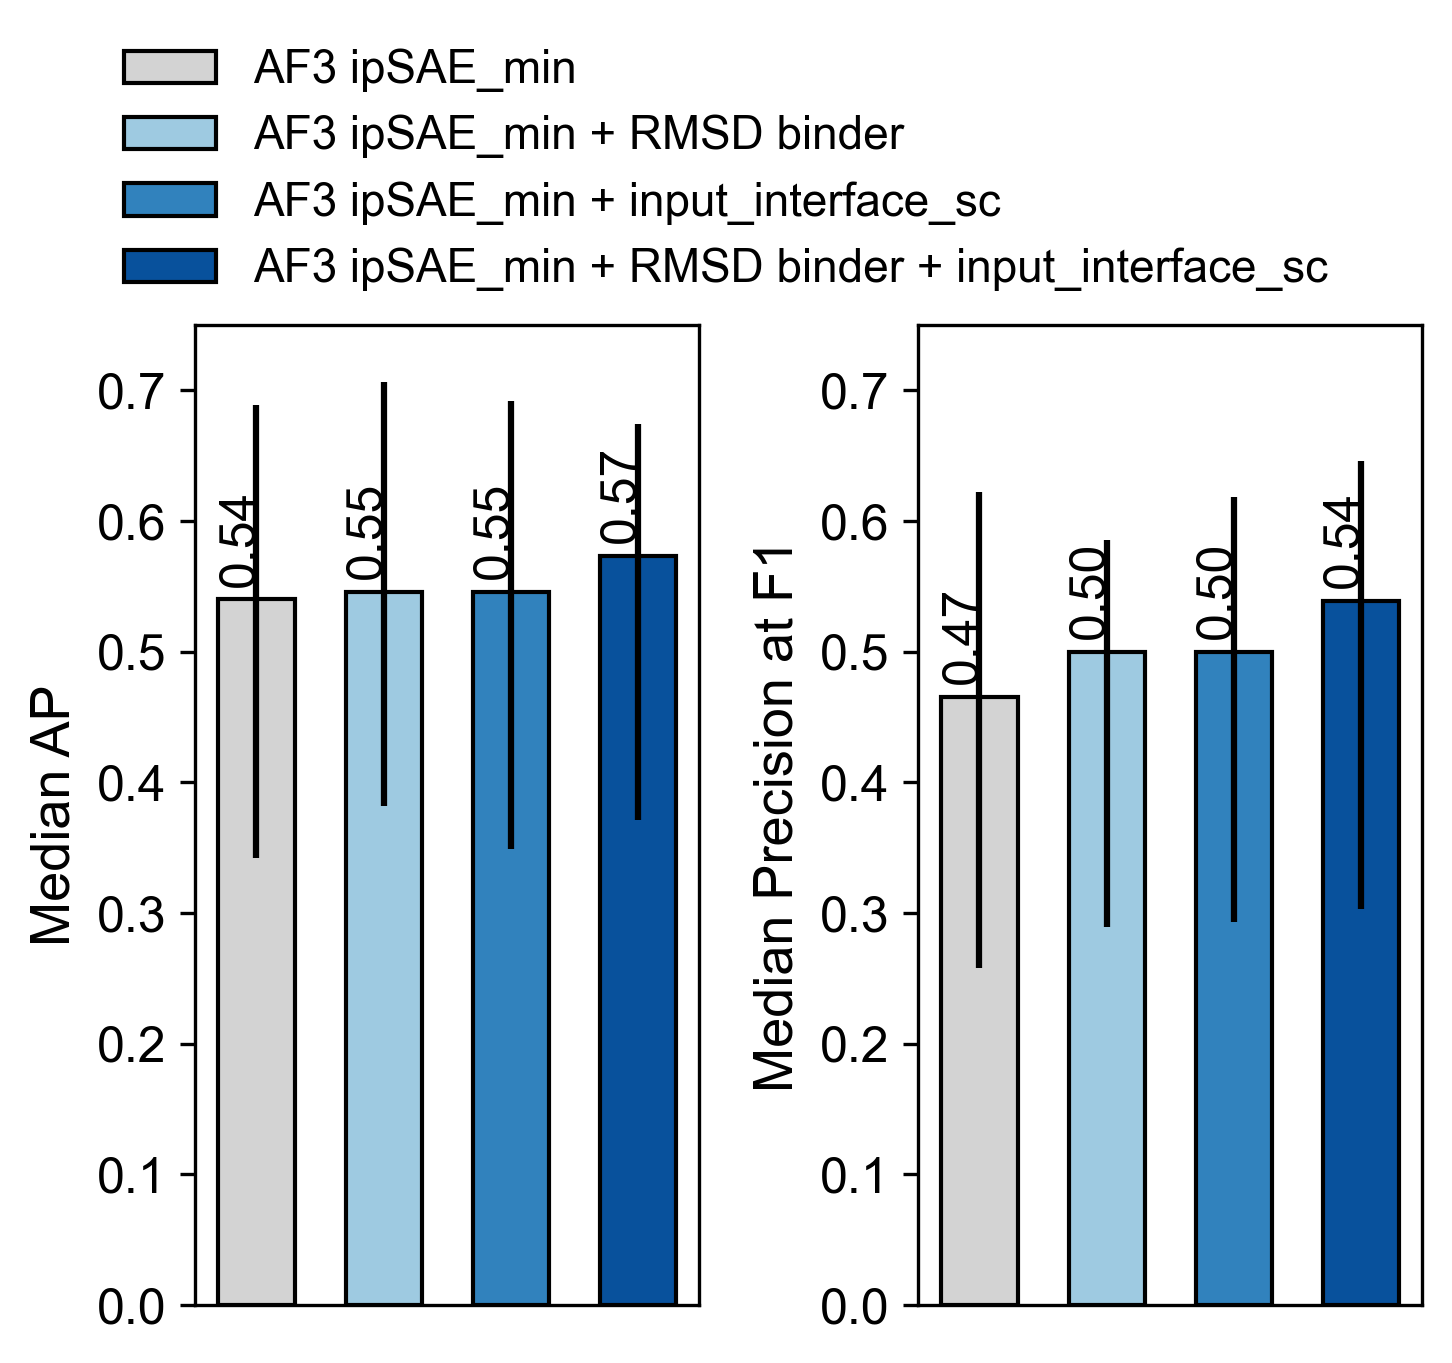

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import nanmedian, nanpercentile
from matplotlib.patches import Patch

# 1) Define feature‐set labels and colors, now including the interface‐only scenario
names = [
    'AF3 ipSAE_min',
    'AF3 ipSAE_min + RMSD binder',
    'AF3 ipSAE_min + input_interface_sc',
    'AF3 ipSAE_min + RMSD binder + input_interface_sc'
]
palette = ['#d3d3d3', '#9ecae1', '#3182bd', '#08519c']

# 2) Extract the arrays from your LOCO-CV results dicts
# Ensure aps and precisions dicts include keys: 'baseline', '+1', '+2', 'both'
ap_arrays   = [
    aps['baseline'],
    aps['+1'],
    aps['+2'],
    aps['both']
]
prec_arrays = [
    precisions['baseline'],
    precisions['+1'],
    precisions['+2'],
    precisions['both']
]

# 3) Compute medians and Q1/Q3 for AP and Precision@F1
ap_meds   = [nanmedian(a) for a in ap_arrays]
ap_q1s    = [nanpercentile(a, 25) for a in ap_arrays]
ap_q3s    = [nanpercentile(a, 75) for a in ap_arrays]

prec_meds = [nanmedian(p) for p in prec_arrays]
prec_q1s  = [nanpercentile(p, 25) for p in prec_arrays]
prec_q3s  = [nanpercentile(p, 75) for p in prec_arrays]

# 4) Build asymmetric errorbars
ap_lower = np.array(ap_meds) - np.array(ap_q1s)
ap_upper = np.array(ap_q3s)  - np.array(ap_meds)
yerr_ap  = np.vstack([ap_lower, ap_upper])

prec_lower = np.array(prec_meds) - np.array(prec_q1s)
prec_upper = np.array(prec_q3s)  - np.array(prec_meds)
yerr_prec  = np.vstack([prec_lower, prec_upper])

# 5) Plot side-by-side
x = np.arange(len(names))
width = 0.6

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 4), dpi=300)

# Median AP bars
bars1 = ax1.bar(x, ap_meds, width, yerr=yerr_ap, capsize=0,
                color=palette, edgecolor='black')
ax1.set_ylabel('Median AP')
#ax1.grid(axis='y', linestyle=':', alpha=0.6)
ax1.set_xticks([])
ax1.set_ylim(0, 0.75)
for bar, med in zip(bars1, ap_meds):
    ax1.text(bar.get_x() + bar.get_width()/2-0.13, bar.get_height() + 0.01,
             f"{med:.2f}", rotation=90, ha='center', va='bottom')

# Precision@F1 bars
bars2 = ax2.bar(x, prec_meds, width, yerr=yerr_prec, capsize=0,
                color=palette, edgecolor='black')
ax2.set_ylabel('Median Precision at F1')
#ax2.grid(axis='y', linestyle=':', alpha=0.6)
ax2.set_xticks([])
ax2.set_ylim(0, 0.75)
for bar, med in zip(bars2, prec_meds):
    ax2.text(bar.get_x() + bar.get_width()/2-0.13, bar.get_height() + 0.01,
             f"{med:.2f}", rotation=90, ha='center', va='bottom')

# Shared legend above
handles = [Patch(facecolor=palette[i], edgecolor='black') for i in range(len(names))]
fig.legend(handles, names, loc='upper center', ncol=1,
           frameon=False, bbox_to_anchor=(0.5, 1.15))

plt.tight_layout(rect=[0,0,1,0.93])
plt.show()

# Top-K filtering AF3 ipSAE_min + RMSD binder + input_interface_sc 

In [43]:
import numpy as np
import pandas as pd

def precision_topk_per_target(
    df: pd.DataFrame,
    group_col: str,
    filters: list,        # list of dicts: [{'feat':…, 'thr':…, 'op':…}, …]
    feature_rank: str,
    k: int = 20,
    rank_op: str = '>'
) -> pd.DataFrame:
    """
    For each group in group_col:
      1) Impute median for each filter feature & the rank feature.
      2) Apply all filters in `filters` sequentially.
      3) Rank remaining rows by `feature_rank` using rank_op (">" for descending, "<" for ascending).
      4) Take the top k and compute precision@k.

    `filters` is a list like:
      [{'feat': featA, 'thr': thrA, 'op': filter_opA},
       {'feat': featB, 'thr': thrB, 'op': filter_opB}]
    """
    results = []
    for grp, sub in df.groupby(group_col):
        sub_mask = pd.Series(True, index=sub.index)
        
        # 1+2) apply each filter
        for filt in filters:
            x = (sub[filt['feat']]
                 .fillna(sub[filt['feat']].median())
                 .values)
            if filt['op'] == '>':
                sub_mask &= (x >= filt['thr'])
            elif filt['op'] == '<':
                sub_mask &= (x <= filt['thr'])
            else:
                raise ValueError("filter op must be '>' or '<'")
        
        sub_f = sub[sub_mask].copy()
        n_filtered = len(sub_f)
        if n_filtered == 0:
            results.append({
                group_col:    grp,
                'n_filtered': 0,
                'n_selected': 0,
                'precision':  np.nan
            })
            continue
        
        # 3) ranking
        x_r = (sub_f[feature_rank]
               .fillna(sub_f[feature_rank].median())
               .values)
        ascending = True if rank_op == '<' else False
        sub_f['_rank_score'] = x_r
        
        sel = sub_f.sort_values('_rank_score', ascending=ascending).head(k)
        n_selected = len(sel)
        
        # 4) precision@k
        prec = sel['binder'].sum() / n_selected if n_selected > 0 else np.nan
        
        results.append({
            group_col:    grp,
            'n_filtered': n_filtered,
            'n_selected': n_selected,
            'precision':  prec
        })
    
    return pd.DataFrame(results)


filters = [
    {'feat': 'RMSD_chA_aft_chB_align_input_af3', 'thr': 3.73, 'op': '<'},
    {'feat': 'input_rosetta_interface_sc',        'thr': 0.62, 'op': '>'},
    
]
feature_rank = 'af3_ipSAE_min'
group_col    = 'target_id'
ks           = list(range(1, 101))

df = pd.read_csv(INPUT_CSV)
summary_rows = []

# define each scenario: no filters, filter1 only, filter2 only, both filters
scenarios = [
    ('AF3 ipSAE_min',       [],             feature_rank),
    ('+RMSD binder < 3.73',      [filters[0]],   feature_rank),
    ('+input_interface_sc > 0.62', [filters[1]],   feature_rank),
    ('+Both Filters',     filters,        feature_rank),
]

for scenario, current_filters, rank_feat in scenarios:
    for k in ks:
        df_res = precision_topk_per_target(
            df,
            group_col,
            filters=current_filters,
            feature_rank=rank_feat,
            k=k,
            rank_op='>'
        )
        mean_prec  = df_res['precision'].mean()
        med_prec   = df_res['precision'].median()
        zero_count = (df_res['precision'] == 0).sum()
        n_targets  = len(df_res)

        summary_rows.append({
            'Scenario':          scenario,
            'k':                 k,
            'Mean Precision':    mean_prec,
            'Median Precision':  med_prec,
            'Zero-Precision #':  zero_count,
            'N Targets':         n_targets
        })

summary_df = pd.DataFrame(summary_rows)

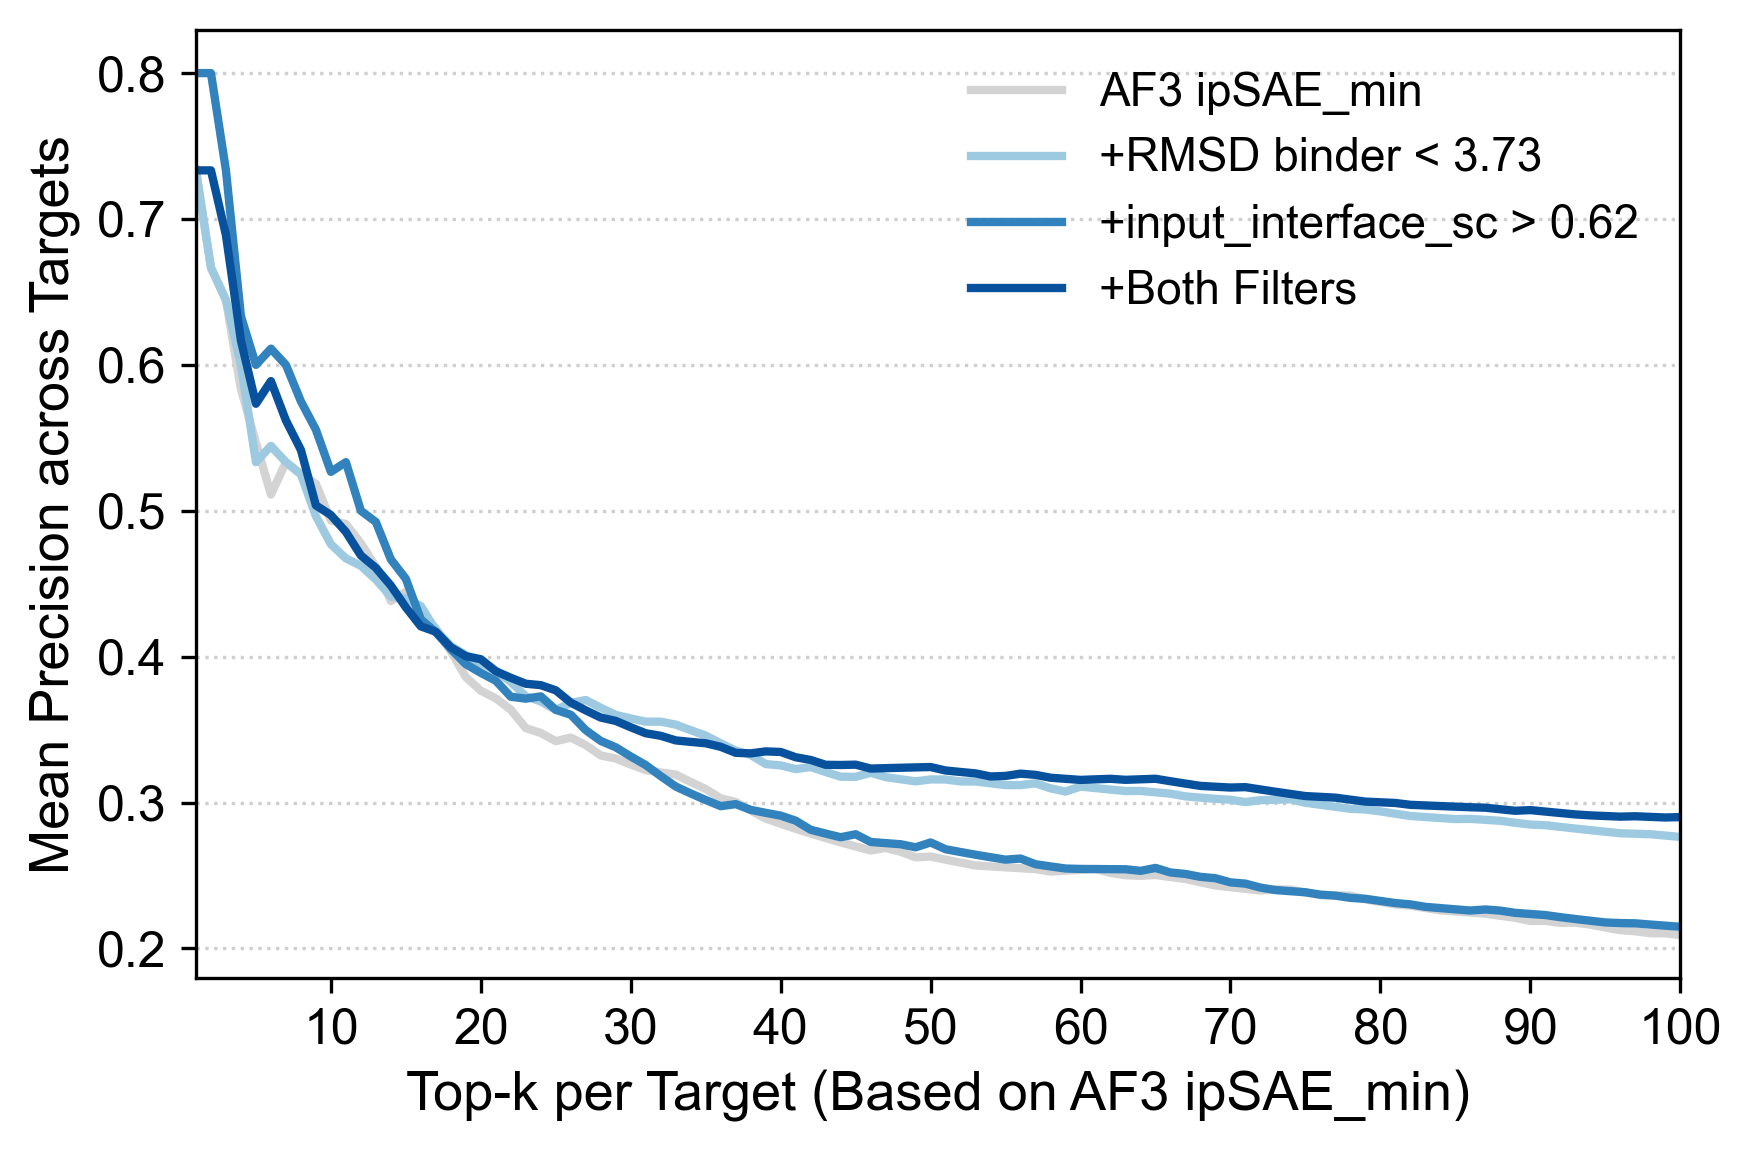

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Assume summary_df is already defined
# Define k-values and x-ticks
ks = list(range(1, 101))
xticks = list(range(10, 101, 10))

# Define your palette: three given plus an additional blue
palette = ['#d3d3d3', '#9ecae1',  '#3182bd','#08519c']

# Get the unique scenarios in the order you want to plot them
scenarios = summary_df['Scenario'].unique().tolist()

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Plot mean precision vs k for each scenario, with specified colors
for color, scenario in zip(palette, scenarios):
    grp = summary_df[summary_df['Scenario'] == scenario]
    ax.plot(grp['k'], grp['Mean Precision'], linestyle='-', linewidth=2,
            color=color, label=scenario)

# Set x-axis ticks at every 10
ax.set_xticks(xticks)
ax.set_xlim(1, 100)

ax.set_xlabel('Top-k per Target (Based on AF3 ipSAE_min)')
ax.set_ylabel('Mean Precision across Targets')

# Show legend
ax.legend(loc='best', frameon=False)

# Add horizontal grid lines
ax.grid(axis='y', linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

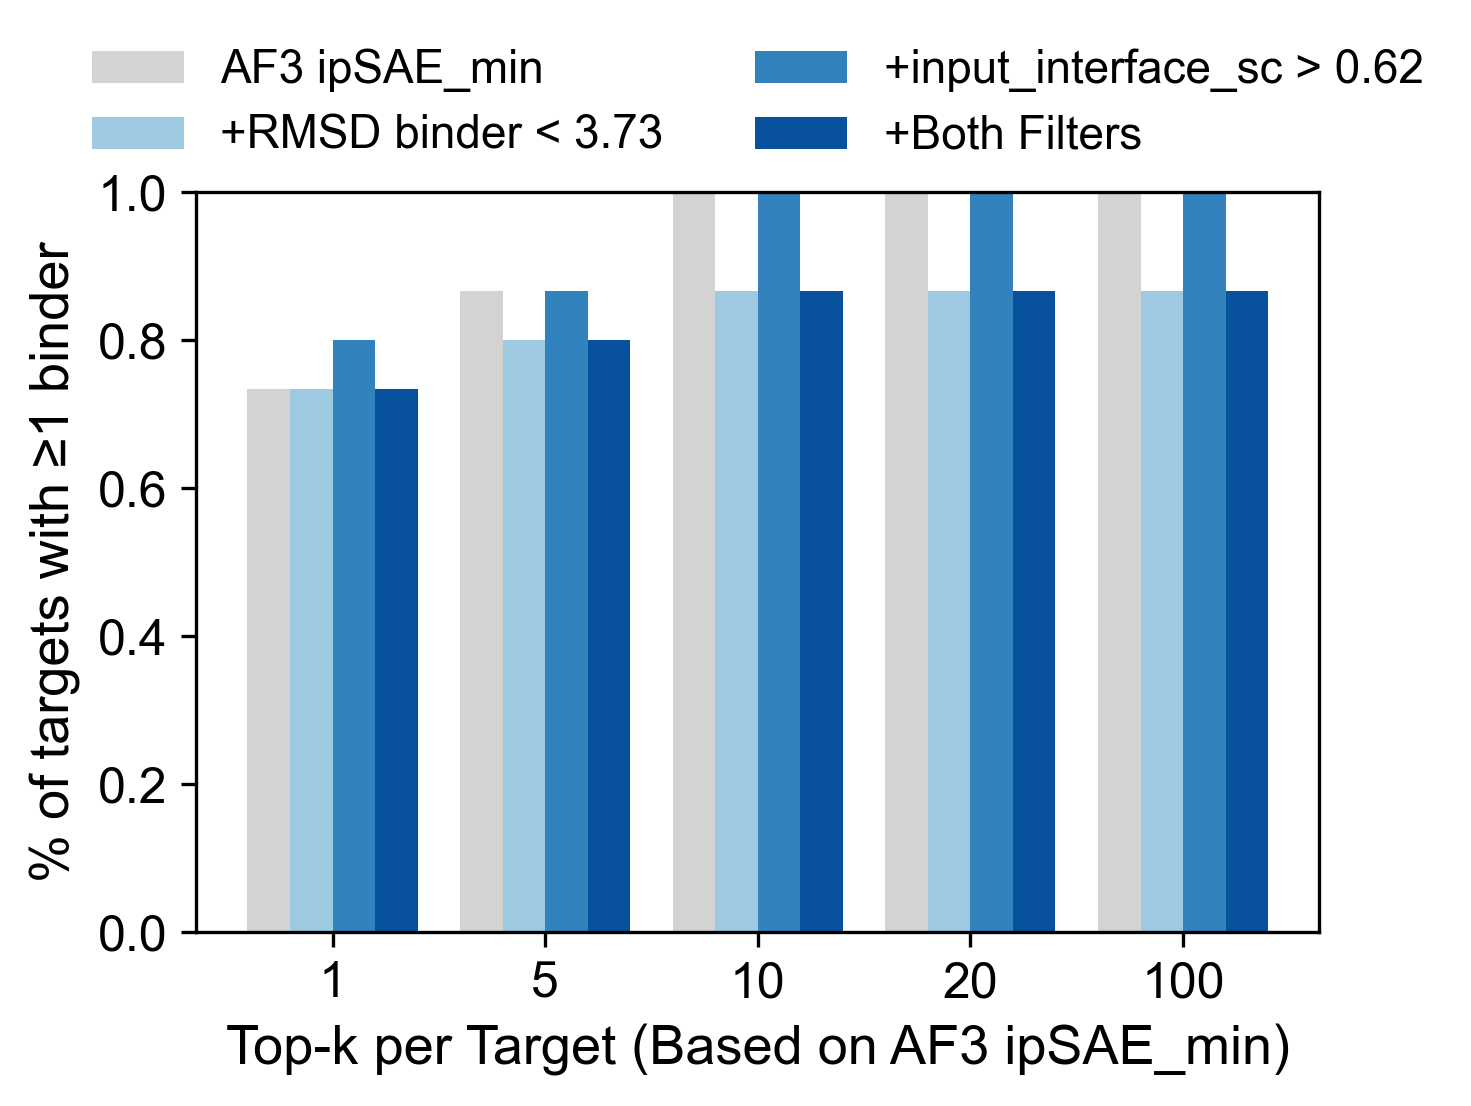

In [45]:
summary_df['Nonzero_Freq'] = (
    (summary_df['N Targets'] - summary_df['Zero-Precision #'])
    / summary_df['N Targets']
)


key_ks = [1, 5, 10, 20,100]
subset = summary_df[summary_df['k'].isin(key_ks)]

fig, ax = plt.subplots(figsize=(5,4), dpi=300)
for idx, scenario in enumerate(subset['Scenario'].unique()):
    vals = subset[subset['Scenario']==scenario]['Nonzero_Freq']
    ax.bar([x + idx*0.2 for x in range(len(key_ks))],
           vals, width=0.2, label=scenario, color=palette[idx])

ax.set_xticks(np.arange(len(key_ks)) + 0.3)
ax.set_xticklabels(key_ks)
ax.set_ylim(0,1)
ax.set_xlabel('Top-k per Target (Based on AF3 ipSAE_min)')
ax.set_ylabel('% of targets with ≥1 binder')
#ax.set_title('% of targets with ≥1 binder')
ax.legend(frameon=False,loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.25))
plt.tight_layout()
plt.show()

